## Задача

В этом соревновании требовалось решить задачу прогнозирования спроса. Результатом работы модели должны быть ровно 2016 прогнозов продаж товаров за три недели в 2015 году.

## Данные

### Описание полей

Num - номер строки в выборке

y - продажи товара c идентификатором item_id за неделю номер week в году year

shift - на сколько недель значения признаков отстают от недели, записанной в week (отставание признаков нужно чтобы научиться прогнозировать продажи на 2 или 3 недели вперед)

f1, ..., f60 - признаки, посчитанные как средние продажи данного товара за разные периоды времени и по разным срезам

## Наблюдения

Было обнаружено полное совпадение f1 & f31, f2 & f32, ... f30 & f60, поэтому последние 30 можно отбросить.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [3]:
print(len(train), len(train[train['f1'] == train['f31']]))

72457 72457


Также, если смотреть по срезам по одинаковым товарам (item_id), можно заметить почти идеальное совпадение (с небольшим сдвигом) между последним признаком (f60 или f30) и целевой функцией y.

In [4]:
def get_feature_times(fr):
    return np.array(fr['year'])*53 + (np.array(fr['week']) - 1) - np.array(fr['shift'])
 
def get_y_times(fr):
    return np.array(fr['year'])*53 + (np.array(fr['week']) - 1)
 
def print_cluster_field(train, _id, field='y', time_shift=1, norm=False, offset=0):
    trainC = train[train['item_id'] == _id][train['shift'] == time_shift]
    data = np.array(trainC[field])
    
    if norm:
        data = (data - np.mean(data))/np.std(data)
    timeC = get_y_times(trainC)
    prepared = []
    
    for i in range(len(timeC)):
        prepared.append((timeC[i],data[i]))
        
    prepared = np.array(sorted(prepared))
    ox = prepared[:,0]
    oy = prepared[:,1]
    plt.plot(ox-offset,oy,label=field)

C:\Users\Andrey\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


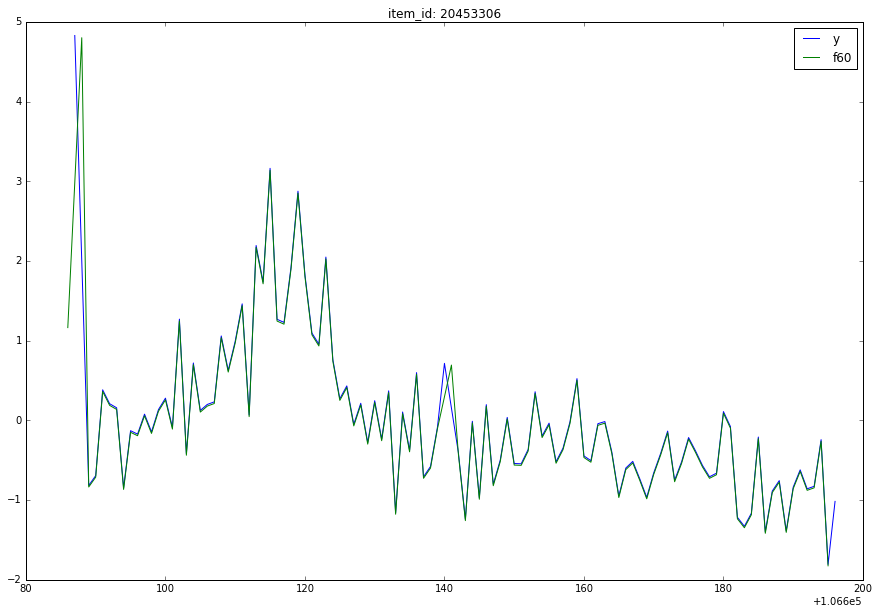

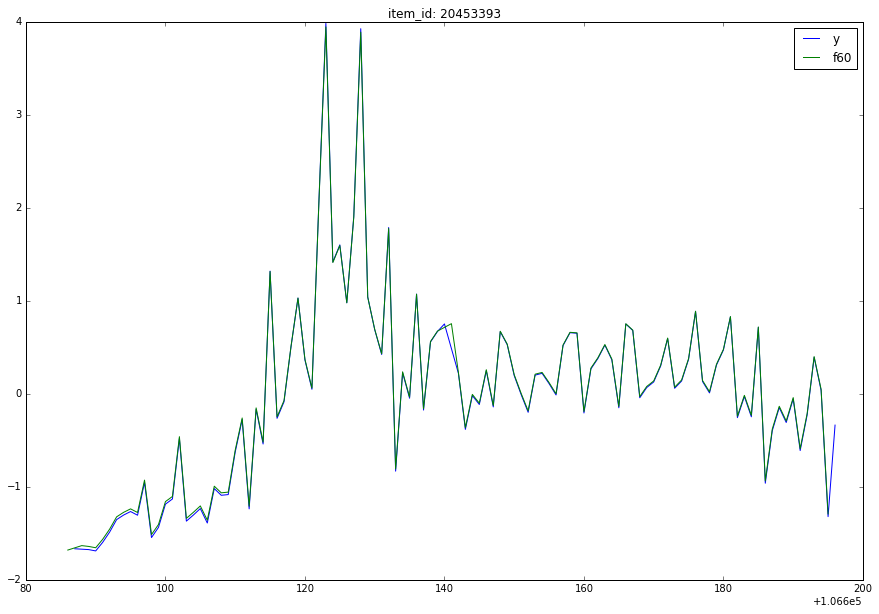

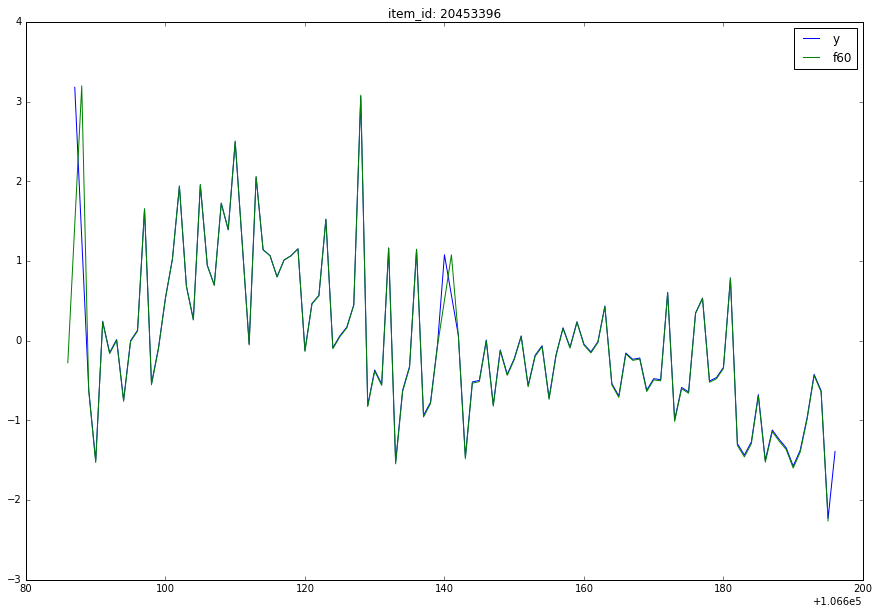

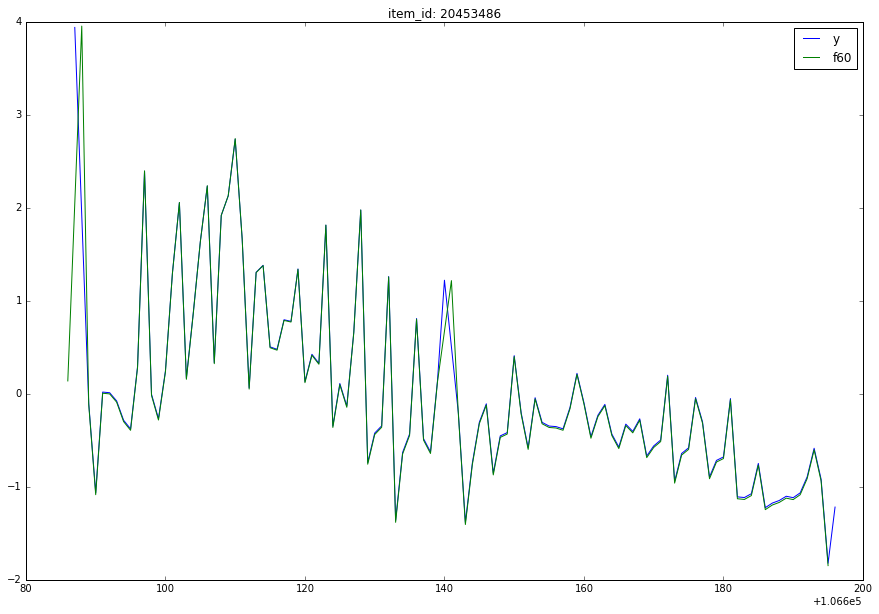

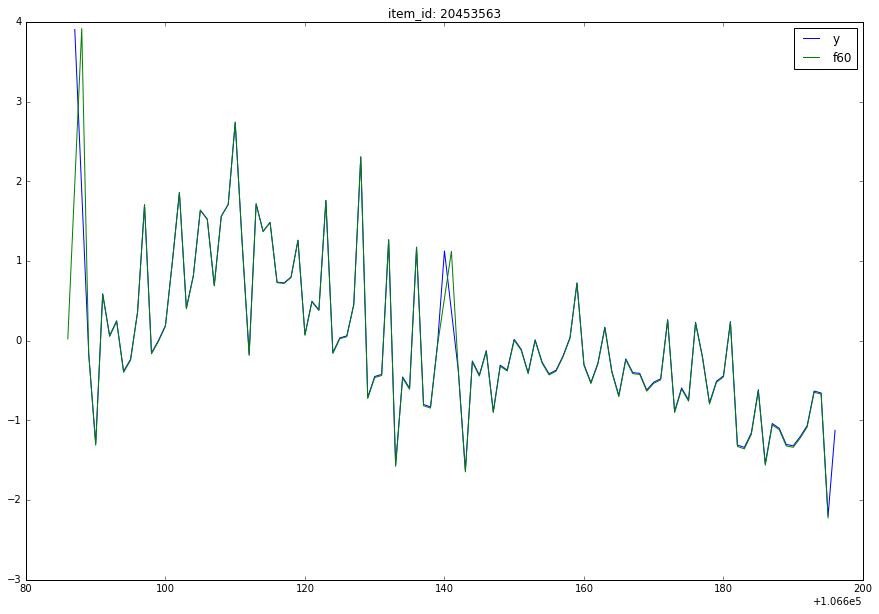

In [6]:
plt.figure(figsize=(15, 10))
shift = 1
for _id in np.unique(train['item_id'])[-5:]:
    plt.figure(figsize=(15, 10))
    print_cluster_field(train, _id, time_shift=shift, field='y', norm=True)
    print_cluster_field(train, _id, time_shift=shift, field='f60', norm=True, offset=shift)
    plt.title('item_id: ' + str(_id))
    plt.legend()
    plt.show()

Обнаружив такое соотношение, грех было не воспользоваться. Моё решение использует эту зависимость (видимо данные примерно так и генерировались). Все ответы на тестовой выборке, кроме последней недели - значения последнего признака (преобразованное) в будующем. Для последней же недели мы не знаем, что случиться. Можно приблизить её предыдущим известным значением.

## Код решения:

In [8]:
# returns times->f60, f60's mean & std
def get_cluster_field(train,_id,field='f60'):
    trainC = train[train['item_id'] == _id]
    data = np.array(trainC[field])

    mean = np.mean(data)
    std = np.std(data)

    data = (data - mean)/std

    timeC = get_feature_times(trainC)
    prepared = dict()
    for i in range(len(timeC)):
        prepared[timeC[i]] = data[i]
        
    return prepared, mean, std

def get_cluster_y_params(train,_id):
    trainC = train[train['item_id'] == _id]
    data = np.array(trainC['y'])

    return np.mean(data), np.std(data)

def get_y(fr, time_to_f60, f60_mean, f60_std, y_mean, y_std):
    f60 = 0
    if (get_feature_times(fr)[0] in time_to_f60.keys()):
        f60 = time_to_f60[get_feature_times(fr)[0]]
    else:
        # return last known
        f60 = time_to_f60[max(time_to_f60.keys())]
    return f60 * y_std + y_mean

def predict(train, test):
    prediction_pairs = []
    for _id in np.unique(test['item_id']):
        time_to_f60, f60_mean, f60_std = get_cluster_field(pd.concat([train, test], axis=0), _id)
        y_mean, y_std = get_cluster_y_params(train, _id)
        
        frame = test[test['item_id'] == _id]
        for i in range(len(frame)):
            prediction_pairs.append((int(frame.iloc[[i]]['Num']), get_y(frame.iloc[[i]], time_to_f60, 
                                                                   f60_mean, f60_std, y_mean, y_std)))
    predictions = sorted(prediction_pairs)
    return predictions

In [9]:
predictions = pd.DataFrame(data=predict(train, test), columns=['Num', 'y'])

К сожалению, как это обычно случается, я взялся за задание слишком поздно, поэтому не успел получить достойный результат.

Помимо вышеизложенного решения, я подбирал параметры к baseline_solution, пробовал random forest. Однако до ума эти решения доведены не были.

Для оценки качества обучение проводилось на первых (по времени) 70% обучающей выборки, а остальная часть использовалась для теста. Вообще же можно брать случайную подвыборку, сортировать по времени и начальную часть использовать для обучения, а конечную для теста.